## 코드를 일부 수정하여, 구현해야 하는 RAG 구조 그림입니다.

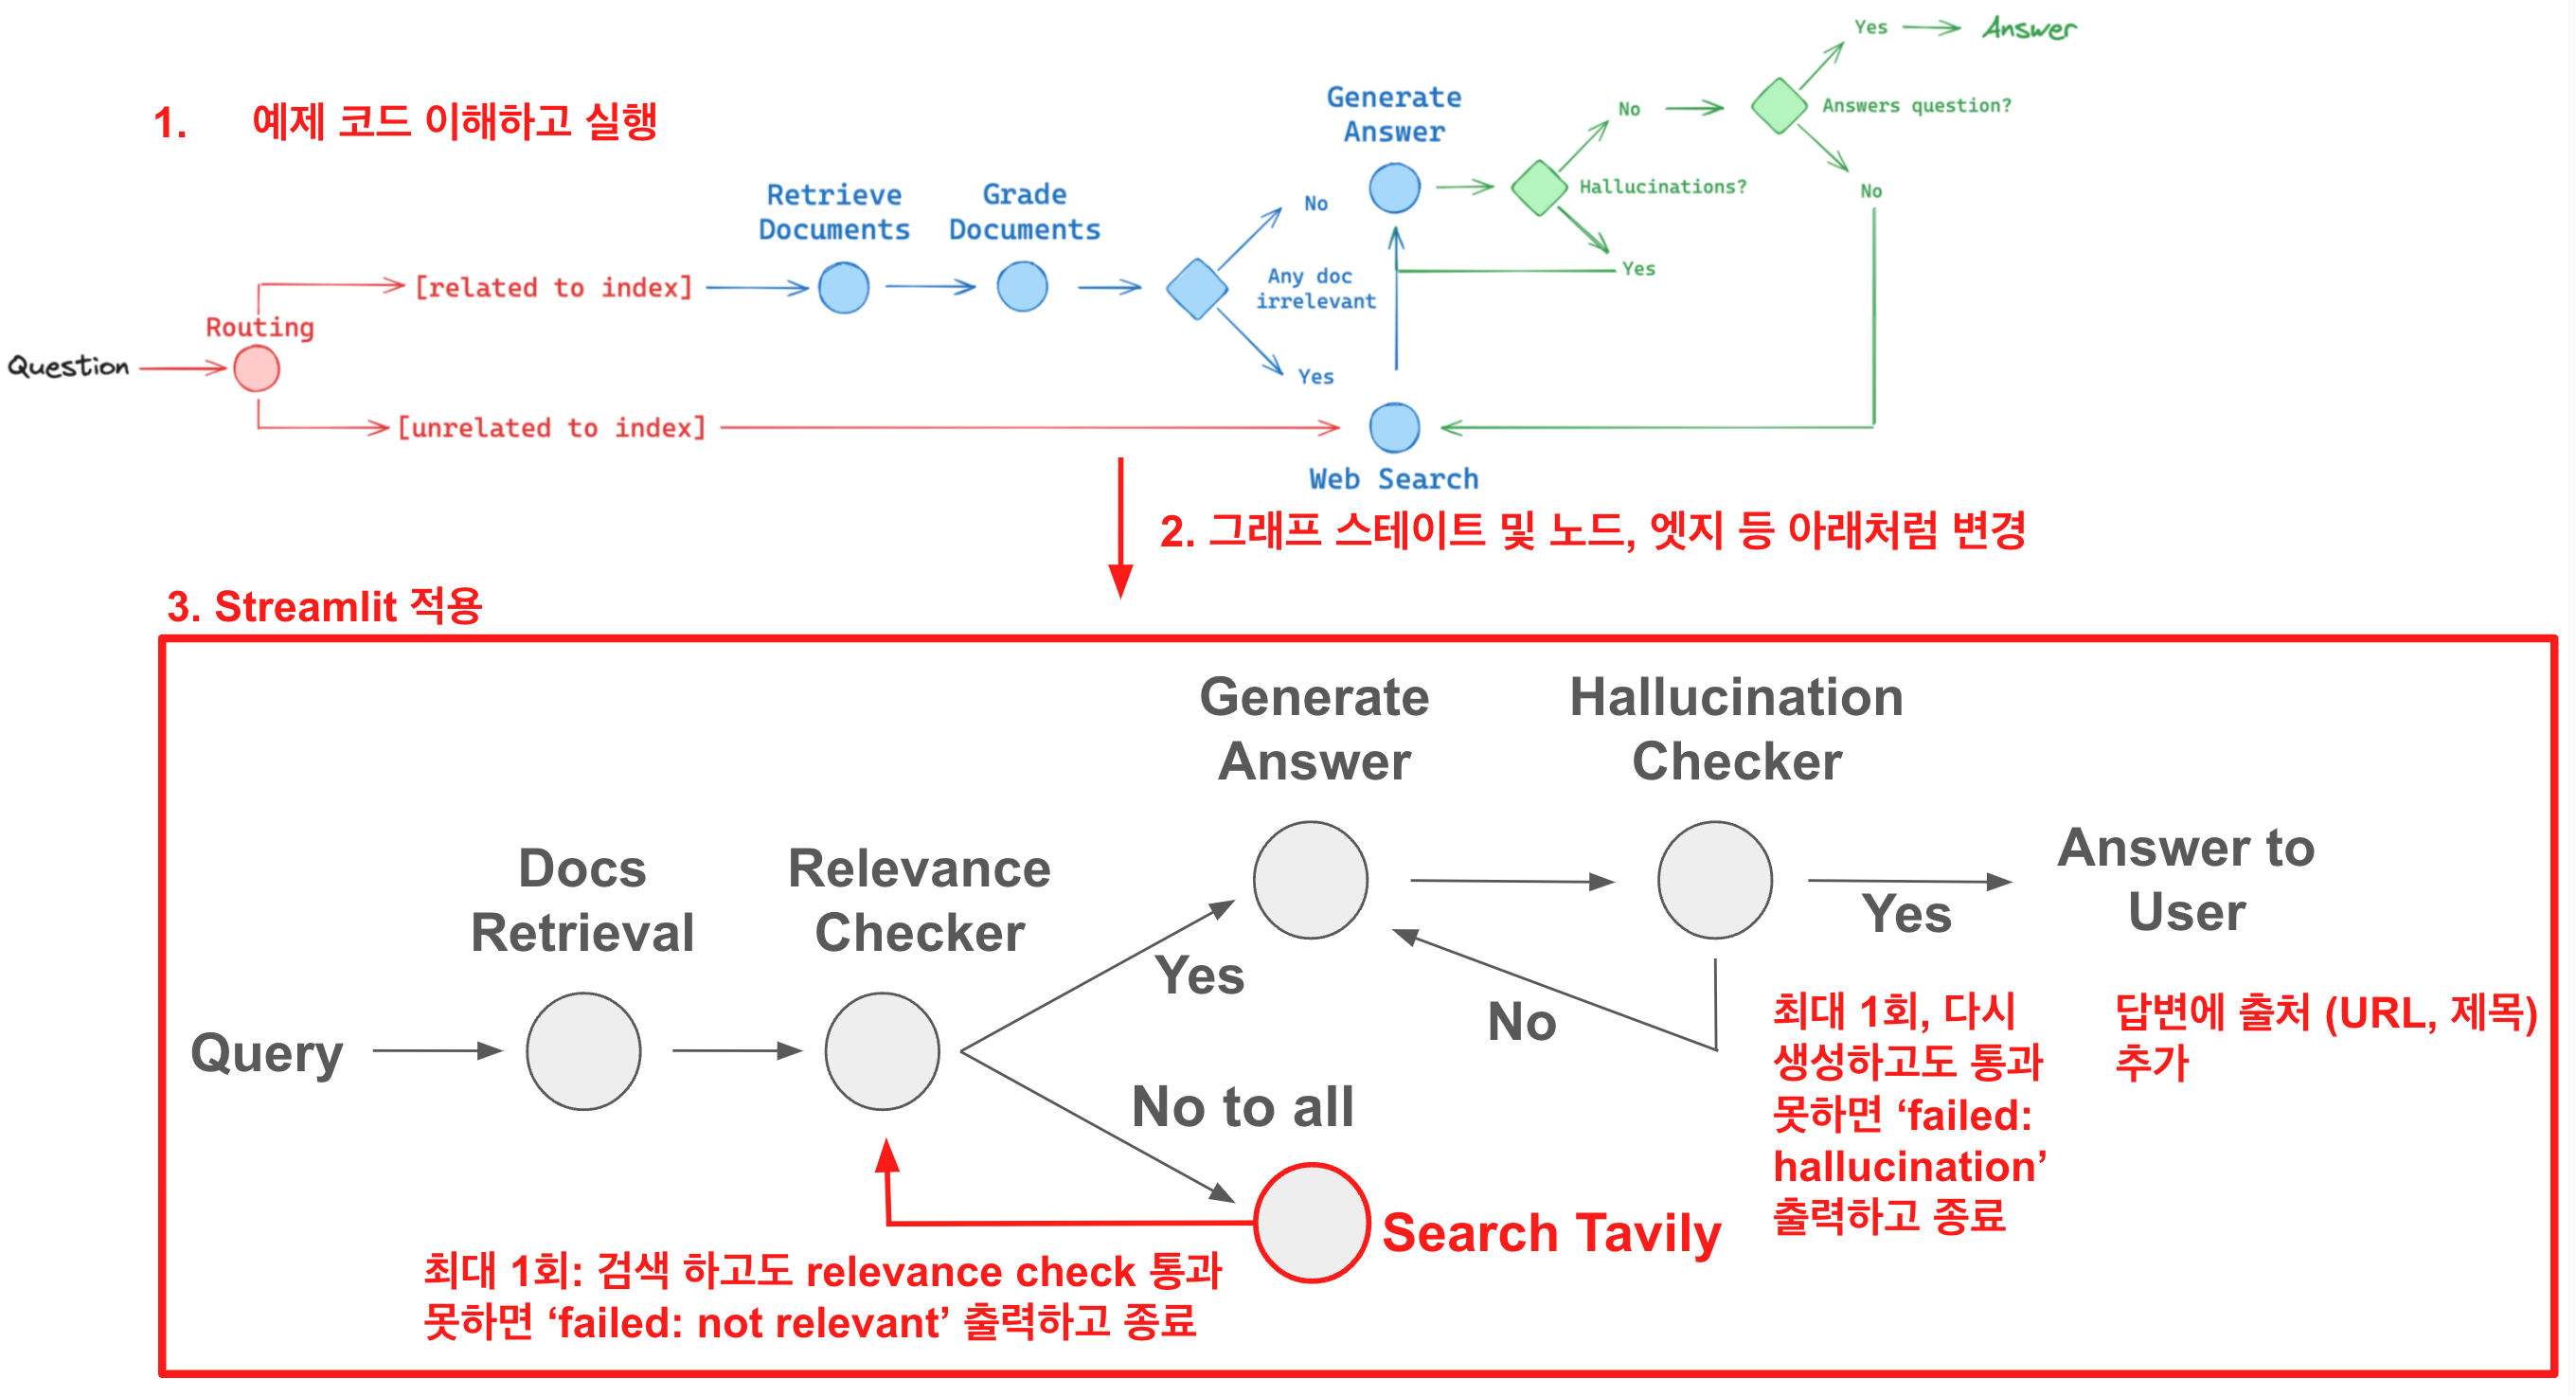


In [ ]:
%%capture --no-stderr
%pip install langchain_community langchainhub chromadb langchain langgraph tavily-python langchain-text-splitters langchain_openai

In [ ]:
from tavily import TavilyClient
import getpass

# Set up the Tavily client
tavily_api_key = getpass.getpass()
tavily = TavilyClient(api_key=tavily_api_key)

response = tavily.search(query="Where does Messi play right now?", max_results=3)
context = [{"url": obj["url"], "content": obj["content"]} for obj in response['results']]

# You can easily get search result context based on any max tokens straight into your RAG.
# The response is a string of the context within the max_token limit.

response_context = tavily.get_search_context(query="Where does Messi play right now?", search_depth="advanced", max_tokens=500)

# You can also get a simple answer to a question including relevant sources all with a simple function call:
# You can use it for baseline
response_qna = tavily.qna_search(query="Where does Messi play right now?")


··········


In [ ]:
from langchain_openai import ChatOpenAI
import os
os.environ['OPENAI_API_KEY'] = getpass.getpass()

llm = ChatOpenAI(model="gpt-4o-mini", temperature = 0)

··········


In [ ]:
### Index

from langchain_community.document_loaders import WebBaseLoader
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding = OpenAIEmbeddings(model="text-embedding-3-small")
)
retriever = vectorstore.as_retriever()

In [ ]:
### Router
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import ChatPromptTemplate

system = """You are an expert at routing a user question to a vectorstore or web search.
Use the vectorstore for questions on LLM agents, prompt engineering, and adversarial attacks.
You do not need to be stringent with the keywords in the question related to these topics.
Otherwise, use web-search. Give a binary choice 'web_search' or 'vectorstore' based on the question.
Return the a JSON with a single key 'datasource' and no premable or explanation. Question to route"""

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "question: {question}"),
    ]
)

question_router = prompt | llm | JsonOutputParser()

# question = "llm agent memory"
question = "What is prompt?"
docs = retriever.get_relevant_documents(question)
print(question_router.invoke({"question": question}))

<ipython-input-5-2feb10edb7c8>:22: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(question)


{'datasource': 'web_search'}


In [ ]:
docs[0].metadata

{'description': 'Prompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for desired outcomes without updating the model weights. It is an empirical science and the effect of prompt engineering methods can vary a lot among models, thus requiring heavy experimentation and heuristics.\nThis post only focuses on prompt engineering for autoregressive language models, so nothing with Cloze tests, image generation or multimodality models. At its core, the goal of prompt engineering is about alignment and model steerability. Check my previous post on controllable text generation.',
 'language': 'en',
 'source': 'https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/',
 'title': "Prompt Engineering | Lil'Log"}

In [ ]:
docs[0].page_content

'Prompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for desired outcomes without updating the model weights. It is an empirical science and the effect of prompt engineering methods can vary a lot among models, thus requiring heavy experimentation and heuristics.\nThis post only focuses on prompt engineering for autoregressive language models, so nothing with Cloze tests, image generation or multimodality models. At its core, the goal of prompt engineering is about alignment and model steerability. Check my previous post on controllable text generation.\n[My personal spicy take] In my opinion, some prompt engineering papers are not worthy 8 pages long, since those tricks can be explained in one or a few sentences and the rest is all about benchmarking. An easy-to-use and shared benchmark infrastructure should be more beneficial to the community. Iterative prompting or external tool use would not be trivial to s

In [ ]:
### Retrieval Grader
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import ChatPromptTemplate

system = """You are a grader assessing relevance
    of a retrieved document to a user question. If the document contains keywords related to the user question,
    grade it as relevant. It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no premable or explanation.
    """

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "question: {question}\n\n document: {document} "),
    ]
)

retrieval_grader = prompt | llm | JsonOutputParser()
question = "What is prompt?"
docs = retriever.invoke(question)
doc_txt = docs[0].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

{'score': 'yes'}


In [ ]:
doc_txt

'Prompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for desired outcomes without updating the model weights. It is an empirical science and the effect of prompt engineering methods can vary a lot among models, thus requiring heavy experimentation and heuristics.\nThis post only focuses on prompt engineering for autoregressive language models, so nothing with Cloze tests, image generation or multimodality models. At its core, the goal of prompt engineering is about alignment and model steerability. Check my previous post on controllable text generation.\n[My personal spicy take] In my opinion, some prompt engineering papers are not worthy 8 pages long, since those tricks can be explained in one or a few sentences and the rest is all about benchmarking. An easy-to-use and shared benchmark infrastructure should be more beneficial to the community. Iterative prompting or external tool use would not be trivial to s

In [ ]:
### Generate

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

system = """You are an assistant for question-answering tasks.
    Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know.
    Use three sentences maximum and keep the answer concise"""

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "question: {question}\n\n context: {context} "),
    ]
)

# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
question = "What is prompt?"
docs = retriever.invoke(question)
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

A prompt is a sequence of tokens used to communicate with language models (LLMs) to influence their behavior and achieve desired outputs without altering the model's weights. It is a key aspect of prompt engineering, which involves experimentation to optimize the effectiveness of these prompts across different models. The goal is to enhance alignment and steerability of the model's responses.


In [ ]:
### Hallucination Grader

system = """You are a grader assessing whether
    an answer is grounded in / supported by a set of facts. Give a binary 'yes' or 'no' score to indicate
    whether the answer is grounded in / supported by a set of facts. Provide the binary score as a JSON with a
    single key 'score' and no preamble or explanation."""

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "documents: {documents}\n\n answer: {generation} "),
    ]
)

hallucination_grader = prompt | llm | JsonOutputParser()
hallucination_grader.invoke({"documents": docs, "generation": generation})

{'score': 'yes'}

In [ ]:
### Answer Grader


prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)


# Prompt
system = """You are a grader assessing whether an
    answer is useful to resolve a question. Give a binary score 'yes' or 'no' to indicate whether the answer is
    useful to resolve a question. Provide the binary score as a JSON with a single key 'score' and no preamble or explanation."""

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "question: {question}\n\n answer: {generation} "),
    ]
)

answer_grader = prompt | llm | JsonOutputParser()
answer_grader.invoke({"question": question, "generation": generation})

{'score': 'yes'}

In [80]:
from pprint import pprint
from typing import List

from langchain_core.documents import Document
from typing_extensions import TypedDict

from langgraph.graph import END, StateGraph

### State
retry = 0

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
    """

    question: str
    generation: str
    web_search: str
    documents: List[str]


### Nodes

def retrieve(state):
    """
    Retrieve documents from vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    print(question)
    print(documents)
    return {"documents": documents, "question": question}


def generate(state):
    """
    Generate answer using RAG on retrieved documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag to run web search

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    web_search = "Yes"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score["score"]
        # Document relevant
        if grade.lower() == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
            web_search = "No"

        # Document not relevant
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            # We do not include the document in filtered_docs
            # We set a flag to indicate that we want to run web search
            state["retry"] = 1


    return {"documents": filtered_docs, "question": question, "web_search": web_search}


def web_search(state):
    """
    Web search based based on the question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appended web results to documents
    """

    print("---WEB SEARCH---")
    print(state)
    question = state["question"]
    documents = None
    if "documents" in state:
      documents = state["documents"]

    # Web search
    docs = tavily.search(query=question)['results']
#    [{'title': 'Where will Lionel Messi play in 2024? Cities, stadiums Inter Miami ...', 'url': 'https://www.sportingnews.com/us/soccer/news/where-lionel-messi-play-2024-inter-miami-cities-road-schedule/23334c5768cebee9021e71d0', 'content': "Here is how Inter Miami's road schedule will look for the coming regular season:\nInter Miami home stadium for 2024 MLS season\nFor their home matches through the 2024 campaign, Inter Miami will once again play at\xa0DRV PNK Stadium in Fort Lauderdale, Florida.\n Cities, stadiums Inter Miami visit on road MLS schedule for new season\nWith Lionel Messi set to embark on his first full season with Inter Miami, fans across the United States will be clamoring to see when the Argentine superstar will visit their city in 2024.\n MLS Season Pass is separate from Apple TV+, meaning those with Apple TV+ would still need an MLS Season Pass subscription to access the complete slate of games, while those without Apple TV+ can still sign up for MLS Season Pass without needing a full Apple TV+ subscription.\n SUBSCRIBE TO MLS SEASON PASS NOW\nApple TV is the official home of the MLS regular season and playoffs, with every match for every team available to stream around the world with no blackouts. How to watch Inter Miami in 2024 MLS season\nLast season, Major League Soccer kicked off a 10-year broadcast rights deal with Apple that sees every single match for the next decade streamed exclusively on Apple's streaming platform.\n", 'score': 0.98612, 'raw_content': None}, {'title': 'Is Lionel Messi playing today? Status for next Inter Miami game in 2024 ...', 'url': 'https://www.sportingnews.com/us/soccer/news/lionel-messi-playing-today-inter-miami-game-2024/129c2c378fee4d1f0102aa9d', 'content': '* Lionel Messi did not participate. Inter Miami schedule for Leagues Cup. The 2024 Leagues Cup is scheduled to begin on July 26, running for a month while the MLS season pauses play.. The final ...', 'score': 0.98209, 'raw_content': None}, {'title': 'Lionel Messi joins Inter Miami: Schedule, MLS tickets to see him play', 'url': 'https://www.usatoday.com/story/sports/mls/2023/06/07/lionel-messi-inter-miami-schedule-tickets/70299298007/', 'content': 'Lionel Messi joins Inter Miami: Full schedule, MLS tickets to see Messi play in US\nLionel Messi\xa0is taking his talents to South Beach.\nMessi,\xa0the 2022 World Cup champion, announced on Wednesday that he will join Major League Soccer\'s Inter Miami CF, a pro soccer club owned by David Beckham, after exiting Ligue 1\'s Paris Saint-Germain following two seasons.\n Tickets to Inter Miami\'s game on June 10 range from $40-$55, but the price tag to see Inter Miami play LigaMX\'s Cruz Azul on July 21 soared to $495 in anticipation of what\'s expected to be Messi\'s first home game, TicketSmarter CEO Jeff Goodman told USA TODAY Sports.\n Each team will play a minimum of two games in the group stage, similar to the World Cup format, with the possibility of more games if the team advances to the knockout rounds.\n "\nAccording to Goodman, nearly 2,000 Inter Miami tickets sold on TicketSmarter the day of Messi\'s announcement Wednesday, compared to under 50 tickets being sold on the platform over the weekend.\n If the Barcelona thing didn\'t work out, I wanted to leave Europe, get out of the spotlight and think more of my family.', 'score': 0.97895, 'raw_content': None}, {'title': "Lionel Messi's 2023 Inter Miami schedule: Every match in MLS, Leagues ...", 'url': 'https://www.sportingnews.com/us/soccer/news/lionel-messi-2023-inter-miami-schedule/d3buao2mhfp7uculkdz3nsc4', 'content': "MORE:\xa0Trophies that Lionel Messi can win with Inter Miami in USA\nLeagues Cup\nIn his first three matches with Inter Miami, Lionel Messi lifted the club into the Leagues Cup Round of 16 thanks to three straight home wins that he helped orchestrate.\n Edition\nLionel Messi's 2023 Inter Miami schedule: Every match in MLS, Leagues Cup and U.S. Open Cup\nLionel Messi is taking North America by storm after scoring in his first three matches for his new club Inter Miami CF.\n MORE: Messi's Miami apartment | Messi's wife & family | Messi's net worth\nLionel Messi, Inter Miami 2023 schedule\nBelow are the remaining games for Inter Miami that Messi will be a part of. MLS\nAfter the Leagues Cup is out of the way, Inter Miami will have 12 MLS matchdays left in a bid to reach the MLS Cup playoffs.\n Inter Miami can still make MLS playoffs\xa0with Lionel Messi\nU.S. Open Cup\nInter Miami reached the semifinal of the competition before Messi and friends joined.", 'score': 0.97298, 'raw_content': None}, {'title': 'Messi, Argentina to play in Chicago, DC before Copa America: More info', 'url': 'https://www.usatoday.com/story/sports/soccer/2024/05/20/messi-argentina-to-play-in-chicago-dc-before-copa-america-more-info/73770204007/', 'content': "1:00. World Cup champion Lionel Messi will participate in two Argentina friendlies early next month before Copa América begins June 20. Messi was officially named to Argentina's 29-man roster ...", 'score': 0.97096, 'raw_content': None}]
#
#

    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results, metadata={"title": docs[0]["title"], "source": docs[0]["url"]})
    if documents is not None:
        documents.append(web_results)
    else:
        documents = [web_results]
    return {"documents": documents, "question": question}


### Edges


def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    print(question)
    source = question_router.invoke({"question": question})
    print(source)
    print(source["datasource"])
    if source["datasource"] == "web_search":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "websearch"
    elif source["datasource"] == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or add web search

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    web_search = state["web_search"]
    state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---"
        )

        if retry >= 1:
            return "failure"

        return "websearch"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


### Conditional edge


def grade_generation_v_documents_and_question(state):
    global retry
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score["score"]

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        pprint("[Source]: " + get_source_str(state["documents"]))
        return "useful"
    else:
        if retry >= 1:
            print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY FAILED")
            state["generation"] = "failed: hallucination"
            return "not useful"
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")

        retry = retry + 1
        return "not supported"

def get_source_str(documents):
    source_str = ""
    for d in documents:
        if d.metadata:
            source_str += d.metadata["title"] + "(" + d.metadata["source"] + ")\n"
    return source_str


workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("websearch", web_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae

In [81]:
# Build graph
workflow.set_entry_point("retrieve")

workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "websearch": "websearch",
        "generate": "generate",
        "failure": END
    },
)

workflow.add_edge("websearch", "grade_documents")

workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": END,
    },
)

In [86]:
# Compile
app = workflow.compile()

# Test
question = "What is RAG"
inputs = {"question": question, "retry": 0}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

---RETRIEVE---
What is RAG
[Document(metadata={'description': 'Prompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for desired outcomes without updating the model weights. It is an empirical science and the effect of prompt engineering methods can vary a lot among models, thus requiring heavy experimentation and heuristics.\nThis post only focuses on prompt engineering for autoregressive language models, so nothing with Cloze tests, image generation or multimodality models. At its core, the goal of prompt engineering is about alignment and model steerability. Check my previous post on controllable text generation.', 'language': 'en', 'source': 'https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/', 'title': "Prompt Engineering | Lil'Log"}, page_content='RAG style, $p(a_i \\mid q) = \\sum_{i=1}^n p_\\text{tf-idf} (p_i \\mid q) \\cdot p_\\text{LM}(a_i \\mid q, p_i)$, where $p_\\text{tf-idf} (p_i \\mi

In [67]:
# 여러 질문을 수행할거라면 document 등 state초기화 필요
document = None
retry = 0